In [76]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import datetime 
from geopy import distance
import folium
from folium.plugins import MarkerCluster

from folium.features import GeoJsonTooltip
from branca.colormap import LinearColormap
from collections import Counter
import json
from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import shape
from shapely.wkt import loads 

In [77]:
data_types = {
    "rideable_type": "category", 
    "start_station_name": "category", 
    "end_station_name": "category", 
    "member_casual":"category",
    # "ride_id":"uint32",
    "time_of_day":"category",
    "trip_type":"category"}

In [3]:
dc_maryland_gdf = pd.read_csv("dc_maryland_gdf_full_updated.csv",parse_dates= ["started_at", "ended_at"],dtype=data_types, low_memory=False)

In [78]:
dc_maryland_gdf.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng,trip_duration_minutes,time_of_day,year,geometry,WARD,NAME,index_right,COUNTY,area
0,classic_bike,2022-01-01 00:04:52,2022-01-01 00:10:40,Thomas Circle,17th & K St NW,casual,38.905900,-77.032500,38.902760,-77.038630,6.0,night,2022,POINT (-77.0325 38.9059),2.0,Ward 2,NaN,NaN,DC
1,electric_bike,2022-01-01 00:05:14,2022-01-01 00:15:39,14th & R St NW,NaN,casual,38.913055,-77.031823,38.930000,-77.050000,10.0,night,2022,POINT (-77.031823 38.9130555),2.0,Ward 2,NaN,NaN,DC
2,classic_bike,2022-01-01 00:06:00,2022-01-01 00:20:47,4th St & Madison Dr NW,10th & K St NW,casual,38.890496,-77.017246,38.902400,-77.026220,15.0,night,2022,POINT (-77.0172465 38.8904955),2.0,Ward 2,NaN,NaN,DC
3,classic_bike,2022-01-01 00:06:01,2022-01-01 00:20:39,4th St & Madison Dr NW,10th & K St NW,casual,38.890496,-77.017246,38.902400,-77.026220,15.0,night,2022,POINT (-77.0172465 38.8904955),2.0,Ward 2,NaN,NaN,DC
4,classic_bike,2022-01-01 00:06:19,2022-01-01 00:12:36,14th & Newton St NW,14th & V St NW,member,38.931991,-77.032956,38.917764,-77.032096,6.0,night,2022,POINT (-77.032956 38.931991),1.0,Ward 1,NaN,NaN,DC


In [4]:
dc_maryland_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12643741 entries, 0 to 12643740
Data columns (total 19 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   rideable_type          category
 1   started_at             object  
 2   ended_at               object  
 3   start_station_name     category
 4   end_station_name       category
 5   member_casual          category
 6   start_lat              float64 
 7   start_lng              float64 
 8   end_lat                float64 
 9   end_lng                float64 
 10  trip_duration_minutes  float64 
 11  time_of_day            category
 12  year                   int64   
 13  geometry               object  
 14  WARD                   float64 
 15  NAME                   object  
 16  index_right            float64 
 17  COUNTY                 object  
 18  area                   object  
dtypes: category(5), float64(7), int64(1), object(6)
memory usage: 1.4+ GB


In [5]:
dc_maryland_gdf["COUNTY"] = dc_maryland_gdf["COUNTY"].astype("category")
dc_maryland_gdf["NAME"] = dc_maryland_gdf["NAME"].astype("category")
dc_maryland_gdf["area"] = dc_maryland_gdf["area"].astype("category")
dc_maryland_gdf["year"] = dc_maryland_gdf["year"].astype("int")


In [80]:
prince_george = dc_maryland_gdf[dc_maryland_gdf["COUNTY"]=="Prince George's"]

In [81]:
prince_george["start_station_name"].nunique()

91

In [6]:
# Rides per year per area
rides_DC = dc_maryland_gdf[dc_maryland_gdf["area"]=="DC"]
rides_maryland = dc_maryland_gdf[dc_maryland_gdf["area"]=="Maryland"]

In [7]:
# # Count rides per area
rides_per_area = dc_maryland_gdf.groupby("area",observed=False).size().reset_index(name="ride_count")  
rides_per_area

,area,ride_count
0,DC,12295725
1,Maryland,348016


In [8]:
rides_per_area_year = dc_maryland_gdf.groupby(["area","year"],observed=False).size().reset_index(name="ride_count")  

In [9]:
rides_per_area_year

,area,year,ride_count
0,DC,2022,3079282
1,DC,2023,3929068
2,DC,2024,5287375
3,Maryland,2022,72354
4,Maryland,2023,97666
5,Maryland,2024,177996


In [10]:
unique_stations_per_area_year = dc_maryland_gdf.groupby(["area","year"],observed=False)["start_station_name"].nunique().reset_index(name="unique_stations")  

In [11]:
unique_stations_per_area_year

,area,year,unique_stations
0,DC,2022,374
1,DC,2023,471
2,DC,2024,495
3,Maryland,2022,119
4,Maryland,2023,192
5,Maryland,2024,215


In [12]:
ride_count_dc_year = rides_DC.groupby("year",observed=False).size().reset_index(name="ride_count") 
ride_count_maryland_year = rides_maryland.groupby("year",observed=False).size().reset_index(name="ride_count") 

In [13]:
ride_count_dc_year

,year,ride_count
0,2022,3079282
1,2023,3929068
2,2024,5287375


In [14]:
ride_count_maryland_year

,year,ride_count
0,2022,72354
1,2023,97666
2,2024,177996


In [15]:
# Ensure 'year' is a string. / year is being treated as a numeric value rather than a categorical one. Seaborn is interpolating between the years and adding extra ticks.
ride_count_dc_year["year"] = ride_count_dc_year["year"].astype(str)
ride_count_maryland_year["year"] = ride_count_maryland_year["year"].astype(str)

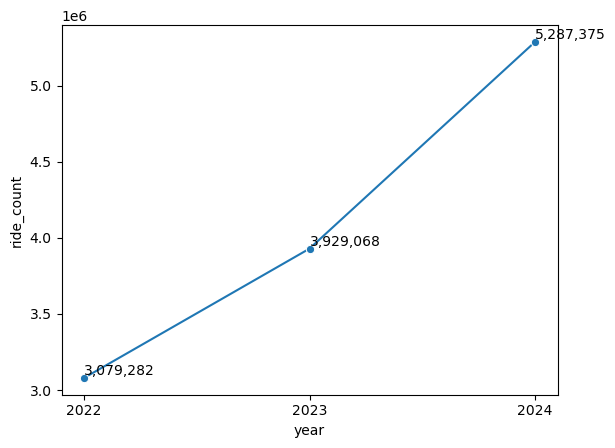

In [16]:
g= sns.lineplot(data=ride_count_dc_year, x ="year", y="ride_count", marker = "o")

for i, row in ride_count_dc_year.iterrows():
    plt.text(row["year"], row["ride_count"], f"{row['ride_count']:,}", 
             ha='left', va='bottom', fontsize=10, color='black')

plt.show()

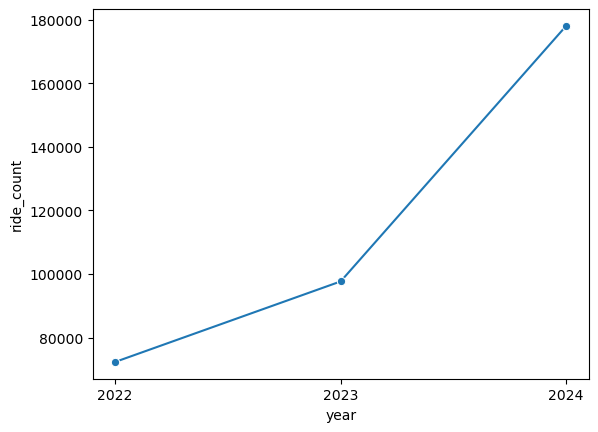

In [17]:
g= sns.lineplot(data=ride_count_maryland_year, x ="year", y="ride_count", marker = "o")


In [18]:
rides_per_area_year["year"] = rides_per_area_year["year"].astype(str)


In [19]:
rides_per_area_year

,area,year,ride_count
0,DC,2022,3079282
1,DC,2023,3929068
2,DC,2024,5287375
3,Maryland,2022,72354
4,Maryland,2023,97666
5,Maryland,2024,177996


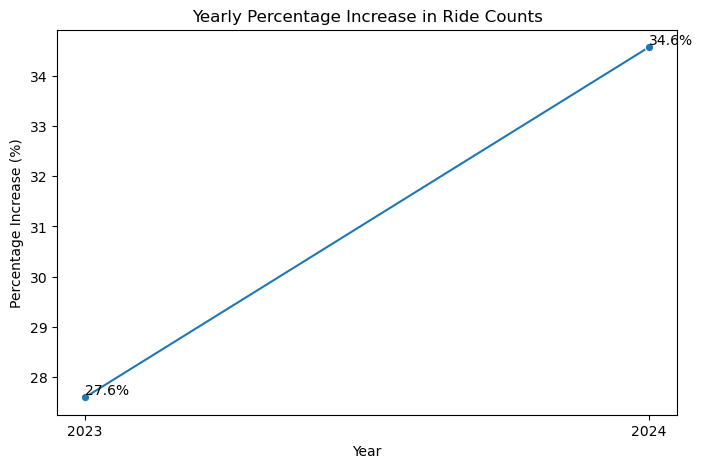

In [20]:
# Calculate percentage increase
ride_count_dc_year["pct_increase"] = ride_count_dc_year["ride_count"].pct_change() * 100
ride_count_maryland_year["pct_increase"] = ride_count_maryland_year["ride_count"].pct_change() * 100

# Ensure 'year' is a string for correct plotting
ride_count_dc_year["year"] = ride_count_dc_year["year"].astype(str)

# Create the line plot
plt.figure(figsize=(8, 5))
g = sns.lineplot(data=ride_count_dc_year, x="year", y="pct_increase", marker="o")

# Add labels next to each marker
for i, row in ride_count_dc_year.iterrows():
    if not pd.isna(row["pct_increase"]):  # Skip NaN for the first year
        plt.text(row["year"], row["pct_increase"], f"{row['pct_increase']:.1f}%", 
                 ha='left', va='bottom', fontsize=10, color='black')

# Labels and title
plt.ylabel("Percentage Increase (%)")
plt.xlabel("Year")
plt.title("Yearly Percentage Increase in Ride Counts")

# Show the plot
plt.show()

In [21]:
ride_count_dc_year

,year,ride_count,pct_increase
0,2022,3079282,NaN
1,2023,3929068,27.596888
2,2024,5287375,34.570718


In [22]:
ride_count_maryland_year

,year,ride_count,pct_increase
0,2022,72354,NaN
1,2023,97666,34.983553
2,2024,177996,82.249708


In [23]:
rides_maryland["COUNTY"].value_counts()

COUNTY
Montgomery         217629
Prince George's    130387
Name: count, dtype: int64

# Prince George County 

In [24]:
with open ("Area_Name_Py.json") as i:
    pg_muni = json.loads(i.read())
features =pg_muni["features"]

In [ ]:
dc_maryland_gdf["geometry"] = dc_maryland_gdf["geometry"].apply(loads)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(dc_maryland_gdf, geometry="geometry")

gdf.set_crs(epsg=4326, inplace=True)

In [32]:
gdf = gdf.drop(columns="index_right")

In [33]:
pg_muni_gdf = gpd.GeoDataFrame(
    pd.DataFrame([feature['properties'] for feature in features]),  # Extract properties as attributes
    geometry=[shape(feature['geometry']) for feature in features],  # Convert geometries
    crs="EPSG:4326")

# # Perform spatial join 
pg = gpd.sjoin(gdf, pg_muni_gdf, how="left", predicate="within")

In [ ]:
# filtering to keep only values of prince george
only_pg = pg[pg["NAME_right"].notnull()]

In [75]:
only_pg.to_csv("prince_georgy_cabi.csv")

In [43]:
only_pg.shape

(130386, 25)

## ride count

In [44]:
only_pg.groupby(["NAME_right"], observed=False).size().reset_index(name="ride_count")


,NAME_right,ride_count
0,ADELPHI,580
1,BELTSVILLE,15
2,CALVERTON,5
3,CAMP SPRINGS,6
4,CARMODY HILLS - PEPPER MILL VILLAGE,18
5,CEDAR HEIGHTS,315
6,CHAPEL OAKS,1394
7,CHILLUM,29244
8,CITY OF COLLEGE PARK,2451
9,CITY OF GREENBELT,4177


In [42]:
only_pg.groupby(["NAME_right","year"], observed=False).size().reset_index(name="ride_count")


,NAME_right,year,ride_count
0,ADELPHI,2022,32
1,ADELPHI,2023,116
2,ADELPHI,2024,432
3,BELTSVILLE,2022,4
4,BELTSVILLE,2023,1
...,...,...,...
129,WALKER MILL,2023,5
130,WALKER MILL,2024,33
131,WOODLAWN,2022,1
132,WOODLAWN,2023,2


## unique stations

In [46]:
#unique stations per year
unique_stations_per_area_year = only_pg.groupby("year",observed=False)["start_station_name"].nunique().reset_index(name="unique_stations") 
unique_stations_per_area_year 

,year,unique_stations
0,2022,28
1,2023,48
2,2024,72


In [51]:
print("unique stations in Prince George in the WHOLE dataset: ", only_pg["start_station_name"].nunique())

unique stations in Prince George in the WHOLE dataset:  89


since in 2024 there were 72 unique stations, this means some stations were taken out of service

In [56]:
#unique stations per city
unique_stations_per_city = only_pg.groupby(["NAME_right"],observed=False)["start_station_name"].nunique().reset_index(name="unique_stations") 
unique_stations_per_city

,NAME_right,unique_stations
0,ADELPHI,0
1,BELTSVILLE,0
2,CALVERTON,0
3,CAMP SPRINGS,0
4,CARMODY HILLS - PEPPER MILL VILLAGE,0
5,CEDAR HEIGHTS,0
6,CHAPEL OAKS,2
7,CHILLUM,18
8,CITY OF COLLEGE PARK,7
9,CITY OF GREENBELT,6


there are rides in many cities, but stations only in a few . combine both to determine which cities need stations
First filter for only 2024


## 2024

In [57]:
only_pg_2024 = only_pg[only_pg["year"]==2024]

In [59]:
unique_stations_per_city_2024 = only_pg_2024.groupby(["NAME_right"],observed=False)["start_station_name"].nunique().reset_index(name="unique_stations") 

In [60]:
unique_stations_per_city_2024

,NAME_right,unique_stations
0,ADELPHI,0
1,BELTSVILLE,0
2,CALVERTON,0
3,CAMP SPRINGS,0
4,CARMODY HILLS - PEPPER MILL VILLAGE,0
5,CEDAR HEIGHTS,0
6,CHAPEL OAKS,1
7,CHILLUM,17
8,CITY OF COLLEGE PARK,7
9,CITY OF GREENBELT,5


In [62]:
ride_count_pg_2024 = only_pg_2024.groupby(["NAME_right"], observed=False).size().reset_index(name="ride_count")
ride_count_pg_2024

,NAME_right,ride_count
0,ADELPHI,432
1,BELTSVILLE,10
2,CALVERTON,5
3,CAMP SPRINGS,5
4,CARMODY HILLS - PEPPER MILL VILLAGE,10
5,CEDAR HEIGHTS,240
6,CHAPEL OAKS,1046
7,CHILLUM,20342
8,CITY OF COLLEGE PARK,1922
9,CITY OF GREENBELT,1748


In [69]:
unique_stations_per_city_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NAME_right       51 non-null     object
 1   unique_stations  51 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 948.0+ bytes


In [72]:
# join between unique stations and number of rides
pg_stations_rides_2024 = unique_stations_per_city_2024.join(ride_count_pg_2024["ride_count"])

In [73]:
pg_stations_rides_2024

,NAME_right,unique_stations,ride_count
0,ADELPHI,0,432
1,BELTSVILLE,0,10
2,CALVERTON,0,5
3,CAMP SPRINGS,0,5
4,CARMODY HILLS - PEPPER MILL VILLAGE,0,10
5,CEDAR HEIGHTS,0,240
6,CHAPEL OAKS,1,1046
7,CHILLUM,17,20342
8,CITY OF COLLEGE PARK,7,1922
9,CITY OF GREENBELT,5,1748
